In [5]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162988 sha256=3f2f59298eddd943b8ca2fabff923cd63b4d5769378677053f79c36160adc4ef
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [1]:
import numpy as np
import pandas as pd
import os
import tqdm
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, mean_squared_error

In [2]:
from movie_lens_data import MovieLensData
from pt_layer import FactorizationMachine, FeaturesEmbedding, FeaturesLinear, MultiLayerPerceptron

In [3]:
path = "/content/drive/MyDrive/Recommender System/movielens_data"
movie_lens_data = MovieLensData(
    users_path = os.path.join(path, "u.user"),
    ratings_path = os.path.join(path, "u.data"),
    movies_path = os.path.join(path, "u.item"),
    genre_path = os.path.join(path, "u.genre")
    )

evaluation_data = movie_lens_data.read_ratings_data()
movie_data = movie_lens_data.read_movies_data()
popularity_rankings = movie_lens_data.get_popularity_ranks()
ratings = movie_lens_data.get_ratings()

In [4]:
movie_data.head()

,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,genre
0,1,Toy Story,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,Animation
1,2,GoldenEye,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,Action
2,3,Four Rooms,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,Thriller
3,4,Get Shorty,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,Action
4,5,Copycat,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,Crime


In [5]:
ratings.info()
ratings.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   user_id   100000 non-null  int64
 1   movie_id  100000 non-null  int64
 2   rating    100000 non-null  int64
dtypes: int64(3)
memory usage: 2.3 MB


,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [6]:
evaluation_data

In [7]:
# dictionary of ranking
type(popularity_rankings), popularity_rankings[50]

(collections.defaultdict, 1)

### Prepare the dataset

In [8]:
print(np.array((0, ), dtype=np.int64))
print(np.array((1, ), dtype=np.int64))

[0]
[1]


In [9]:
class MovieLensDataset(torch.utils.data.Dataset):
  """
  MovieLens Dataset
  Data Preparation
    treat samples with a rating less than 3 as negative samples
  """

  def __init__(self, ratings):
    data = ratings.copy().to_numpy()
    self.items = data[:, :2].astype(np.int32) - 1 # -1 because ID begins from 1
    self.targets = self.__preprocess_target(data[:, 2]).astype(np.float32)
    # maximum values among the column + 1
    self.field_dims = np.max(self.items, axis=0) + 1
    self.user_field_idx = np.array((0, ), dtype=np.int64)
    self.item_field_idx = np.array((1, ), dtype=np.int64)

  def __len__(self):
    return self.targets.shape[0]

  def __getitem__(self, index):
    return self.items[index], self.targets[index]

  def __preprocess_target(self, target):
    target = target / 5
    return target

In [10]:
def get_dataset():
  return MovieLensDataset(ratings)

In [11]:
dataset = MovieLensDataset(ratings)
print(dataset[0])
for data in dataset:
  print(data)
  print(data[0])
  break

(array([195, 241], dtype=int32), 0.6)
(array([195, 241], dtype=int32), 0.6)
[195 241]


### Prepare the algoritmn

In [12]:
class FactorizationMachineModel(torch.nn.Module):
  """
  A pytorch implementation of Factorization Machine.
  """

  def __init__(self, field_dims, embed_dim):
    super().__init__()
    self.embedding = FeaturesEmbedding(field_dims, embed_dim)
    self.linear = FeaturesLinear(field_dims)
    self.fm = FactorizationMachine(reduce_sum=True)

  def forward(self, x):
    """
    x : Long tensor of size ``(batch_size, num_fields)``
    """
    x = self.linear(x) + self.fm(self.embedding(x))
    return torch.sigmoid(x.squeeze(1))

In [13]:
def get_model(dataset):
  field_dims = dataset.field_dims
  return FactorizationMachineModel(field_dims, embed_dim = 64)

In [14]:
class EarlyStopper(object):
  def __init__(self, num_trials, save_path, lower_is_better=True):
    self.num_trials = num_trials
    self.trial_counter = 0
    self.lower_is_better = lower_is_better
    if self.lower_is_better:
      self.best_accuracy = 1_000_000
    else:
      self.best_accuracy = 0
    self.save_path = save_path

  def is_continuable(self, model, accuracy):
        print(f"ES accuracy: {accuracy}")
        if (self.lower_is_better and accuracy < self.best_accuracy) or\
           (not self.lower_is_better and accuracy > self.best_accuracy) :
            self.best_accuracy = accuracy
            self.trial_counter = 0
            torch.save(model, self.save_path)
            return True
        elif self.trial_counter + 1 < self.num_trials:
            self.trial_counter += 1
            return True
        else:
            return False

In [15]:
def train(model, optimizer, data_loader, criterion, device, log_interval=100):
  model.train()
  total_loss = 0
  av_loss = []
  tk0 = tqdm.tqdm(data_loader, smoothing = 0, mininterval=1.0)
  for i, (field, target) in enumerate(tk0):
    # fields: <class 'torch.Tensor'> torch.Size([64, 2])
    fields, target = field.to(device), target.to(device)
    # y: <class 'torch.Tensor'> torch.Size([64])
    y = model(fields)
    loss = criterion(y, target.float())
    model.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    if (i + 1) % log_interval == 0:
      loss = total_loss / log_interval
      av_loss.append(loss)
      tk0.set_postfix(loss = loss)
      total_loss = 0

  return np.mean(av_loss)


In [16]:
def test(model, data_loader, device):
  model.eval()
  targets, predicts = list(), list()
  with torch.no_grad():
    for fields, target in tqdm.tqdm(data_loader, smoothing=0, mininterval=1.0):
      fields, target = fields.to(device), target.to(device)
      y = model(fields)
      targets.extend(target.tolist())
      predicts.extend(y.tolist())
  return 5. * mean_squared_error(targets, predicts)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.001
weight_decay = 1e-4
batch_size = 64
epochs = 20
model_name = "DeepFM"

### Prepare train, valid, and test dataset

In [18]:
dataset = get_dataset()
train_length = int(len(dataset) * 0.8)
valid_length = int(len(dataset) * 0.1)
test_length = len(dataset) - train_length - valid_length

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, (train_length, valid_length, test_length))

num_workers = os.cpu_count()

train_data_loader = DataLoader(train_dataset, batch_size = batch_size, num_workers=num_workers, pin_memory=True)
valid_data_loader = DataLoader(valid_dataset, batch_size = batch_size, num_workers = num_workers, pin_memory=True)
test_data_loader = DataLoader(test_dataset, batch_size = batch_size, num_workers = num_workers, pin_memory=True)

### Fit the model

In [19]:
model = get_model(dataset).to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr=learning_rate, weight_decay=weight_decay)
early_stopper = EarlyStopper(num_trials=5, save_path=f'{model_name}.pt')

In [20]:
metric_values = []
loss_values = []

for epoch_i in range(epochs):
  loss = train(model, optimizer, train_data_loader, criterion, device)
  loss_values.append((epoch_i, loss))

  metric_valid = test(model, valid_data_loader, device)
  print('epoch: ', epoch_i + 1, 'validation: mae:', metric_valid)

  metric_train = test(model, train_data_loader, device)
  print("train mae: ", metric_train)

  metric_test = test(model, test_data_loader, device)
  print(f'test mae: {metric_test}')
  metric_values.append((epoch_i, metric_train, metric_valid, metric_test))

  if not early_stopper.is_continuable(model, metric_valid):
    print(f'validation: best mae: {early_stopper.best_accuracy}')
    break

  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 378.87it/s]


epoch:  1 validation: mae: 0.33488022052769156


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1250/1250 [00:02<00:00, 448.57it/s]


train mae:  0.3250595741915568


  0%|          | 0/157 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 377.49it/s]


test mae: 0.32517673699665905
ES accuracy: 0.33488022052769156


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 369.60it/s]


epoch:  2 validation: mae: 0.26741143951235674


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1250/1250 [00:04<00:00, 286.48it/s]


train mae:  0.2570568663693833


  0%|          | 0/157 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 274.31it/s]


test mae: 0.26082644325299725
ES accuracy: 0.26741143951235674


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 210.12it/s]


epoch:  3 validation: mae: 0.23757761007834427


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1250/1250 [00:08<00:00, 151.22it/s]


train mae:  0.22694848674184415


  0%|          | 0/157 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:01<00:00, 145.88it/s]


test mae: 0.23201724940710766
ES accuracy: 0.23757761007834427


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 366.85it/s]


epoch:  4 validation: mae: 0.22082322084509715


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1250/1250 [00:02<00:00, 448.12it/s]


train mae:  0.21080680471488628


  0%|          | 0/157 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 380.36it/s]


test mae: 0.2159934390041523
ES accuracy: 0.22082322084509715


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 379.96it/s]


epoch:  5 validation: mae: 0.20947681476967578


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1250/1250 [00:02<00:00, 449.40it/s]


train mae:  0.20035239570526706


  0%|          | 0/157 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 364.54it/s]


test mae: 0.20509175886379183
ES accuracy: 0.20947681476967578


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 263.01it/s]


epoch:  6 validation: mae: 0.20135288352495984


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1250/1250 [00:07<00:00, 173.73it/s]


train mae:  0.19304665101031926


  0%|          | 0/157 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 371.05it/s]


test mae: 0.19719794287919273
ES accuracy: 0.20135288352495984


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 360.47it/s]


epoch:  7 validation: mae: 0.19580491289383645


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1250/1250 [00:02<00:00, 419.87it/s]


train mae:  0.1881218645033539


  0%|          | 0/157 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 243.99it/s]


test mae: 0.19178624561702798
ES accuracy: 0.19580491289383645


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 371.81it/s]


epoch:  8 validation: mae: 0.1922571422852557


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1250/1250 [00:02<00:00, 454.69it/s]


train mae:  0.18498200549589422


  0%|          | 0/157 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 366.42it/s]


test mae: 0.1883436465512644
ES accuracy: 0.1922571422852557


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 238.06it/s]


epoch:  9 validation: mae: 0.19004148072528856


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1250/1250 [00:04<00:00, 304.69it/s]


train mae:  0.18297137788151835


  0%|          | 0/157 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 358.43it/s]


test mae: 0.18622138992157952
ES accuracy: 0.19004148072528856


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 375.18it/s]


epoch:  10 validation: mae: 0.1886549287758803


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1250/1250 [00:02<00:00, 442.31it/s]


train mae:  0.1816415226332182


  0%|          | 0/157 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 257.00it/s]


test mae: 0.18491832741316883
ES accuracy: 0.1886549287758803


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 381.24it/s]


epoch:  11 validation: mae: 0.18780902191313983


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1250/1250 [00:02<00:00, 450.70it/s]


train mae:  0.18078721767288908


  0%|          | 0/157 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 366.09it/s]


test mae: 0.18413138151251093
ES accuracy: 0.18780902191313983


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 225.62it/s]


epoch:  12 validation: mae: 0.18729079112642485


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1250/1250 [00:04<00:00, 297.02it/s]


train mae:  0.18023982092575858


  0%|          | 0/157 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 357.68it/s]


test mae: 0.18364936720480365
ES accuracy: 0.18729079112642485


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 366.63it/s]


epoch:  13 validation: mae: 0.18696565779716928


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1250/1250 [00:02<00:00, 428.21it/s]


train mae:  0.17988899701998476


  0%|          | 0/157 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 233.62it/s]


test mae: 0.18334661267729133
ES accuracy: 0.18696565779716928


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 94%|█████████▎| 1171/1250 [00:06<00:00, 187.46it/s, loss=0.571]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 349.57it/s]


epoch:  14 validation: mae: 0.186756020139109


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1250/1250 [00:02<00:00, 450.08it/s]


train mae:  0.17966322981577493


  0%|          | 0/157 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 362.60it/s]


test mae: 0.18315040134288865
ES accuracy: 0.186756020139109


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 230.12it/s]


epoch:  15 validation: mae: 0.18661707239649655


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1250/1250 [00:04<00:00, 312.47it/s]


train mae:  0.17951138043251014


  0%|          | 0/157 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 363.71it/s]


test mae: 0.18302020502204874
ES accuracy: 0.18661707239649655


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 366.25it/s]


epoch:  16 validation: mae: 0.18652447382601814


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1250/1250 [00:02<00:00, 435.28it/s]


train mae:  0.1794105629291133


  0%|          | 0/157 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 235.86it/s]


test mae: 0.18293345750527912
ES accuracy: 0.18652447382601814


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 82%|████████▏ | 1026/1250 [00:06<00:01, 152.08it/s, loss=0.571]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 355.98it/s]


epoch:  17 validation: mae: 0.18645979879719565


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1250/1250 [00:02<00:00, 452.48it/s]


train mae:  0.17934112552750664


  0%|          | 0/157 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 362.44it/s]


test mae: 0.18287311405774512
ES accuracy: 0.18645979879719565


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 204.22it/s]


epoch:  18 validation: mae: 0.18641494559328484


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1250/1250 [00:05<00:00, 239.70it/s]


train mae:  0.17929251111064745


  0%|          | 0/157 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 280.17it/s]


test mae: 0.18282995603604252
ES accuracy: 0.18641494559328484


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 374.79it/s]


epoch:  19 validation: mae: 0.18638228506700608


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1250/1250 [00:02<00:00, 447.79it/s]


train mae:  0.17925898196230283


  0%|          | 0/157 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 371.10it/s]


test mae: 0.18279981169255016
ES accuracy: 0.18638228506700608


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 82%|████████▏ | 1025/1250 [00:06<00:01, 152.87it/s, loss=0.571]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 371.29it/s]


epoch:  20 validation: mae: 0.18635833649776476


  0%|          | 0/1250 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1250/1250 [00:02<00:00, 444.44it/s]


train mae:  0.1792337827934509


  0%|          | 0/157 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:00<00:00, 355.46it/s]

test mae: 0.18277771109964921
ES accuracy: 0.18635833649776476


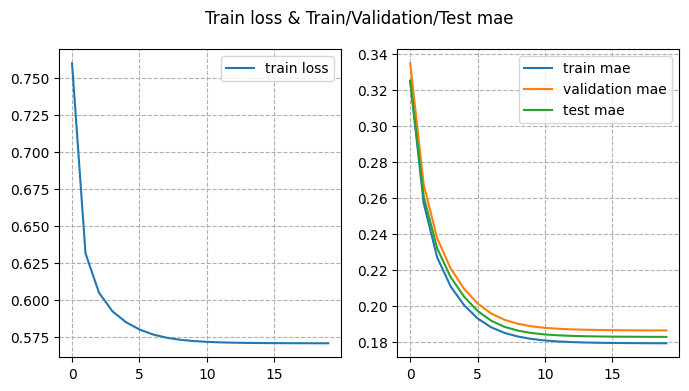

In [21]:
from matplotlib import pyplot as plt
metric_values = np.array(metric_values)
loss_values = [x[1] for x in loss_values]
f, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].plot(loss_values, label="train loss")
ax[0].legend()
ax[0].grid(linestyle="--",which="major")

ax[1].plot(metric_values[:, 1], label="train mae")
ax[1].plot(metric_values[:, 2], label="validation mae")
ax[1].plot(metric_values[:, 3], label="test mae")
ax[1].legend()
ax[1].grid(linestyle="--",which="major")
plt.suptitle("Train loss & Train/Validation/Test mae")
plt.show()

### load the model

In [22]:
save_path = "DeepFM.pt"
loaded_model = torch.load(save_path)
loaded_model.eval()

FactorizationMachineModel(
  (embedding): FeaturesEmbedding(
    (embedding): Embedding(2625, 64)
  )
  (linear): FeaturesLinear(
    (fc): Embedding(2625, 1)
  )
  (fm): FactorizationMachine()
)

In [29]:
data = [[22, 377]]
sample_data = torch.tensor(data)
loaded_model(sample_data) * 5

tensor([3.6200], grad_fn=<MulBackward0>)

In [30]:
ratings.head()

,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1
